In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [19]:
data_dir='/content/drive/MyDrive/Augment_Audio_files'
class_names = ["belly_pain", "burping", "discomfort", "hungry", "tired"]


**Below is the code for Visualization for the Audio files before feature Extraction**

In [20]:
# Function to plot waveform
def plot_waveform(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Function to plot spectrogram
def plot_spectrogram(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    S = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(S))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram: {os.path.basename(audio_file)}")
    plt.show()

# Function to plot duration distribution of all audio files
def plot_duration_distribution():
    durations = []
    for class_name in class_names:
        folder_path = os.path.join(data_dir, class_name)
        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".wav")]
        for file in files:
            y, sr = librosa.load(file, sr=None)
            durations.append(len(y) / sr)  # Convert samples to time (seconds)

    plt.figure(figsize=(8, 5))
    sns.histplot(durations, bins=20, kde=True)
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Count")
    plt.title("Distribution of Audio Durations")
    plt.show()

# Function to plot class distribution
def plot_class_distribution():
    class_counts = {}
    for class_name in class_names:
        folder_path = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(os.listdir(folder_path))

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="muted")
    plt.xlabel("Cry Type")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution Before Feature Extraction")
    plt.xticks(rotation=30)
    plt.show()

<ipython-input-20-7bf61ef4f360>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="muted")


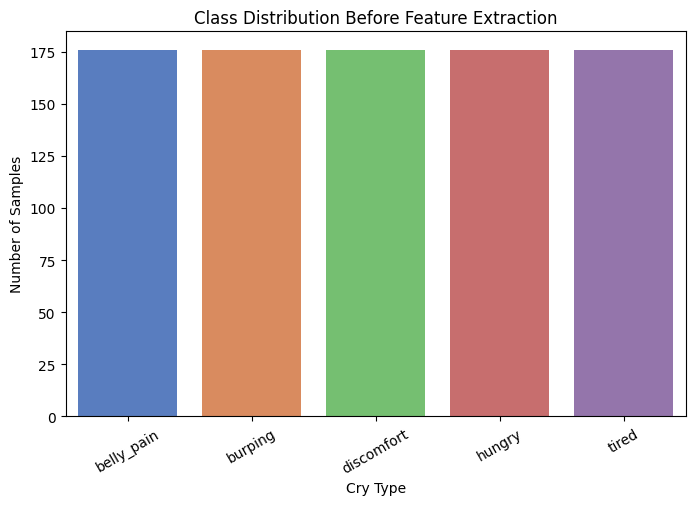

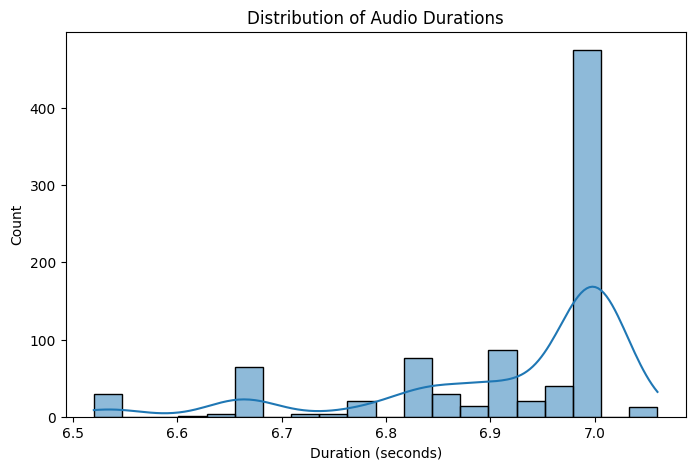

 Visualizing: /content/drive/MyDrive/Augment_Audio_files/discomfort/1309B82C-F146-46F0-A723-45345AFA6EA8-1430704008-1_aug_9.wav


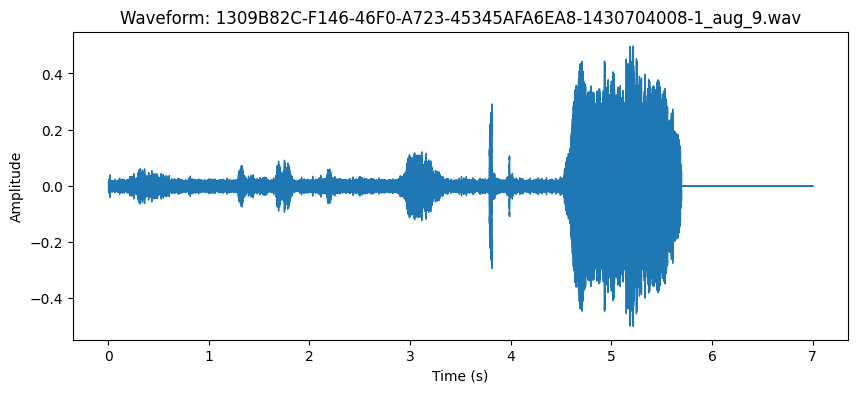

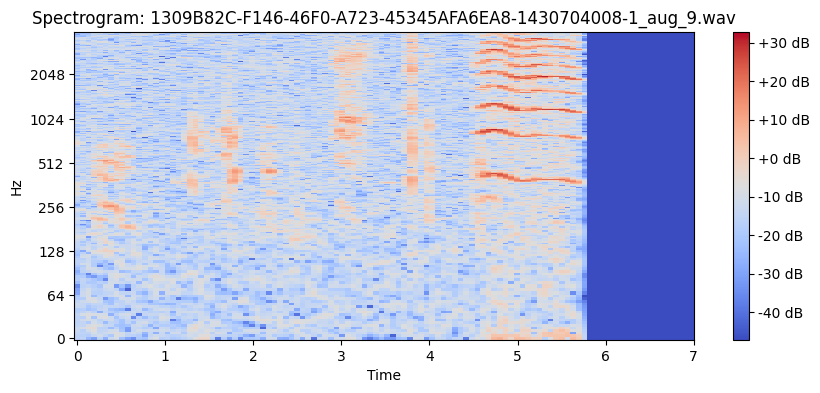

In [21]:
# Run the plots
plot_class_distribution()
plot_duration_distribution()

# Pick a random sample for waveform and spectrogram visualization
import random
sample_class = random.choice(class_names)
sample_folder = os.path.join(data_dir, sample_class)
sample_file = random.choice([os.path.join(sample_folder, f) for f in os.listdir(sample_folder) if f.endswith(".wav")])

print(f" Visualizing: {sample_file}")
plot_waveform(sample_file)
plot_spectrogram(sample_file)

**Code to Load and Organize the data**

In [22]:
DATASET_PATH = "/content/drive/MyDrive/Augment_Audio_files"

# Define classes
classes = ["tired", "hungry", "discomfort", "burping", "belly_pain"]

# Dictionary to store audio data
audio_data = {cls: [] for cls in classes}

# Load all audio files
for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    for file in os.listdir(class_path):
        if file.endswith(".wav"):  # Ensure only audio files are processed
            file_path = os.path.join(class_path, file)
            y, sr = librosa.load(file_path, sr=22050)
            y, _ = librosa.effects.trim(y)  # Trim silence
            max_length = sr * 3  # Standardize to 3 seconds
            y = librosa.util.fix_length(y, size=max_length)
            audio_data[cls].append(y)

print("Loaded Audio Data for All Classes!")

Loaded Audio Data for All Classes!


**Visualizing Waveforms for All classes **

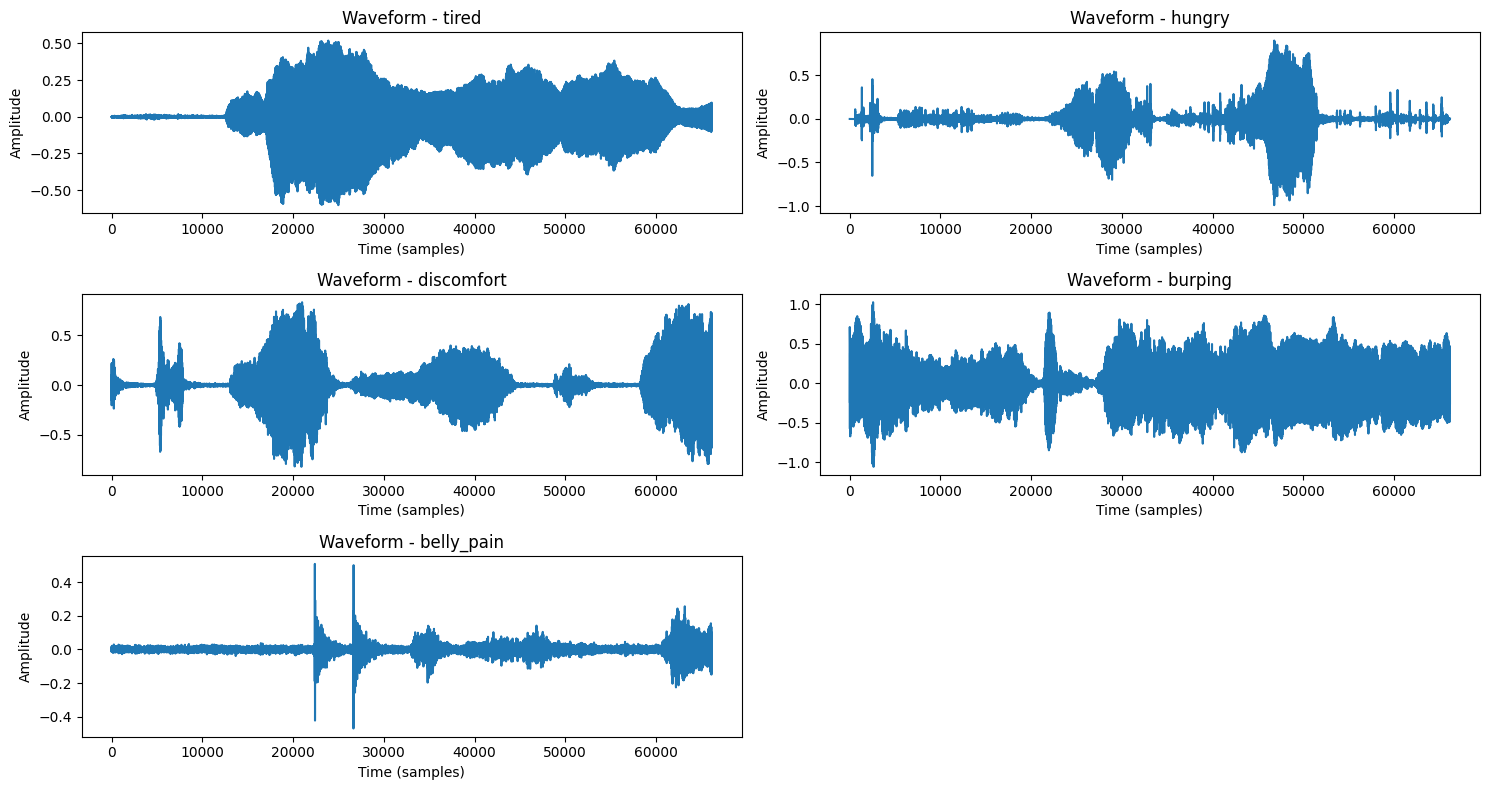

In [17]:
plt.figure(figsize=(15, 8))

for i, cls in enumerate(classes):
    if len(audio_data[cls]) > 0:
        plt.subplot(3, 2, i + 1)  # Arrange plots in a grid
        plt.plot(audio_data[cls][0])  # Plot the first sample from each class
        plt.title(f"Waveform - {cls}")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


**Extract Features for All Audio Files**

In [23]:
features=[]
labels=[]

for cls in classes:
  for y in audio_data[cls]:
    mfccs=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=13)
    mfccs_mean=np.mean(mfccs.T,axis=0)  #Convert to 1d

    mel_spec=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=128,fmax=8000)
    mel_spec_mean=np.mean(librosa.power_to_db(mel_spec).T,axis=0)  #Convert to 1D

    chroma=librosa.feature.chroma_stft(y=y,sr=sr)
    chroma_mean=np.mean(chroma.T, axis=0)  #COnvert to 1D

    feature_vector = np.hstack([mfccs_mean, mel_spec_mean, chroma_mean])
    features.append(feature_vector)
    labels.append(cls)

print(f"Extracted Features for {len(features)} Audio Files!")

Extracted Features for 880 Audio Files!


**Visualizing Extracted Features**

We can plot:
  1. MFCC heatmap
  2. Mel Spectrogram
  3. chroma Features

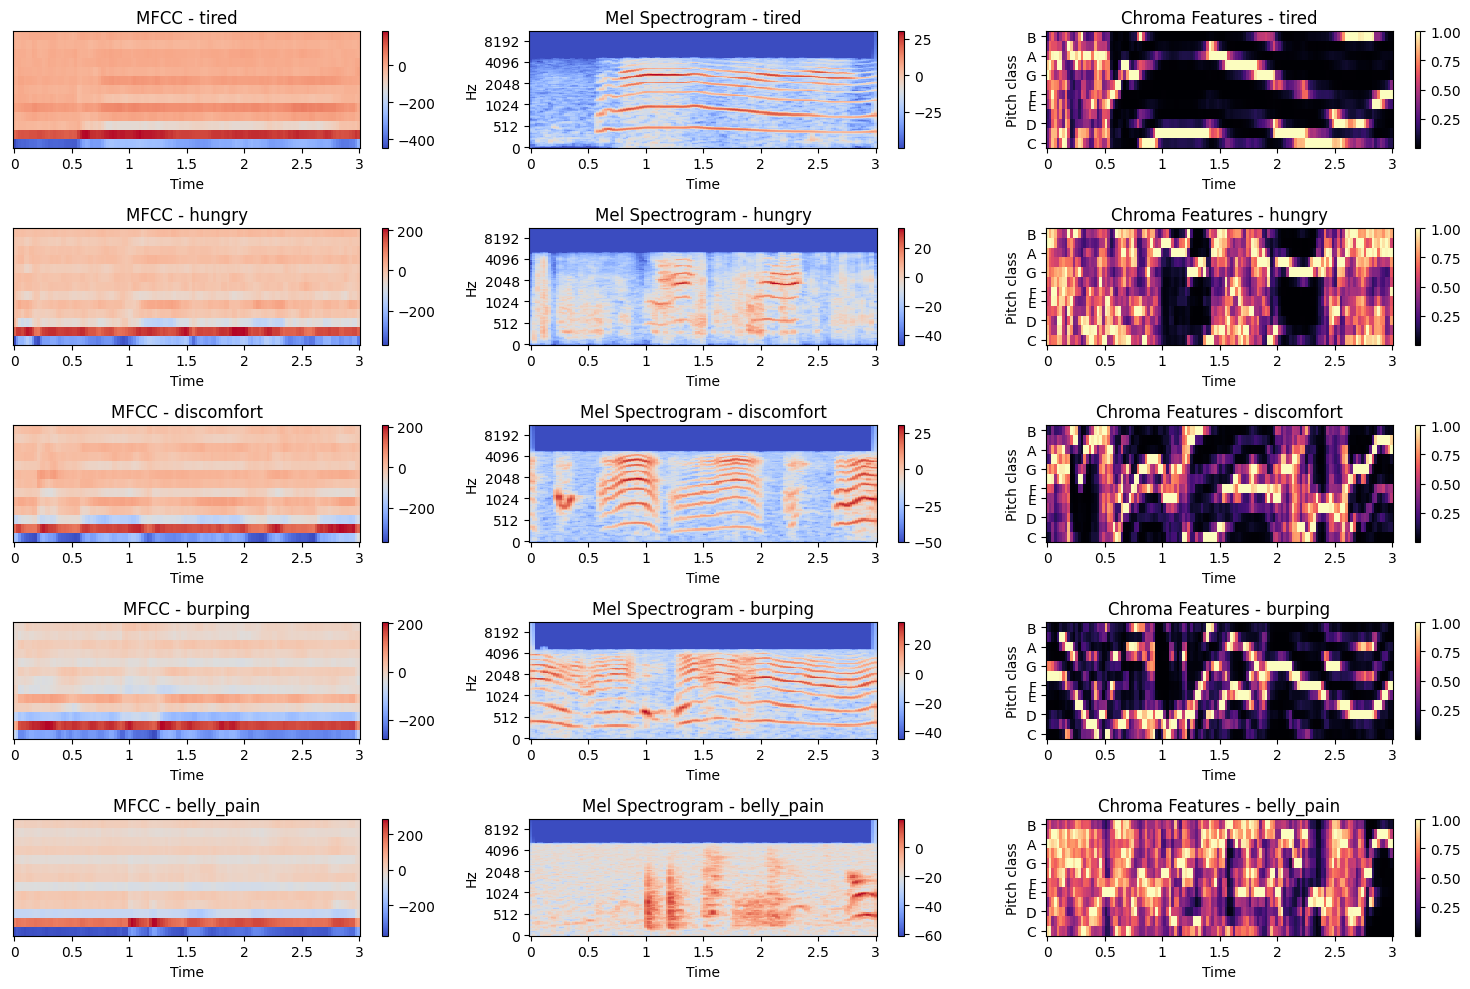

In [24]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))  # Adjust figure size

for i, cls in enumerate(classes):
    if len(audio_data[cls]) > 0:
        sample_audio = audio_data[cls][0]  # First audio sample of the class
        plt.subplot(len(classes), 3, i * 3 + 1)  # MFCC
        mfccs = librosa.feature.mfcc(y=sample_audio, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, x_axis="time")
        plt.colorbar()
        plt.title(f"MFCC - {cls}")

        plt.subplot(len(classes), 3, i * 3 + 2)  # Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=sample_audio, sr=sr, n_mels=128, fmax=8000)
        librosa.display.specshow(librosa.power_to_db(mel_spec), x_axis="time", y_axis="mel", sr=sr)
        plt.colorbar()
        plt.title(f"Mel Spectrogram - {cls}")

        plt.subplot(len(classes), 3, i * 3 + 3)  # Chroma Features
        chroma = librosa.feature.chroma_stft(y=sample_audio, sr=sr)
        librosa.display.specshow(chroma, x_axis="time", y_axis="chroma", sr=sr)
        plt.colorbar()
        plt.title(f"Chroma Features - {cls}")

plt.tight_layout()
plt.show()



**Spectral Features (Spectral Centroid, Spectral Bandwidth, Spectral Contrast)**
These features capture how frequencies are distributed in a cry sound.


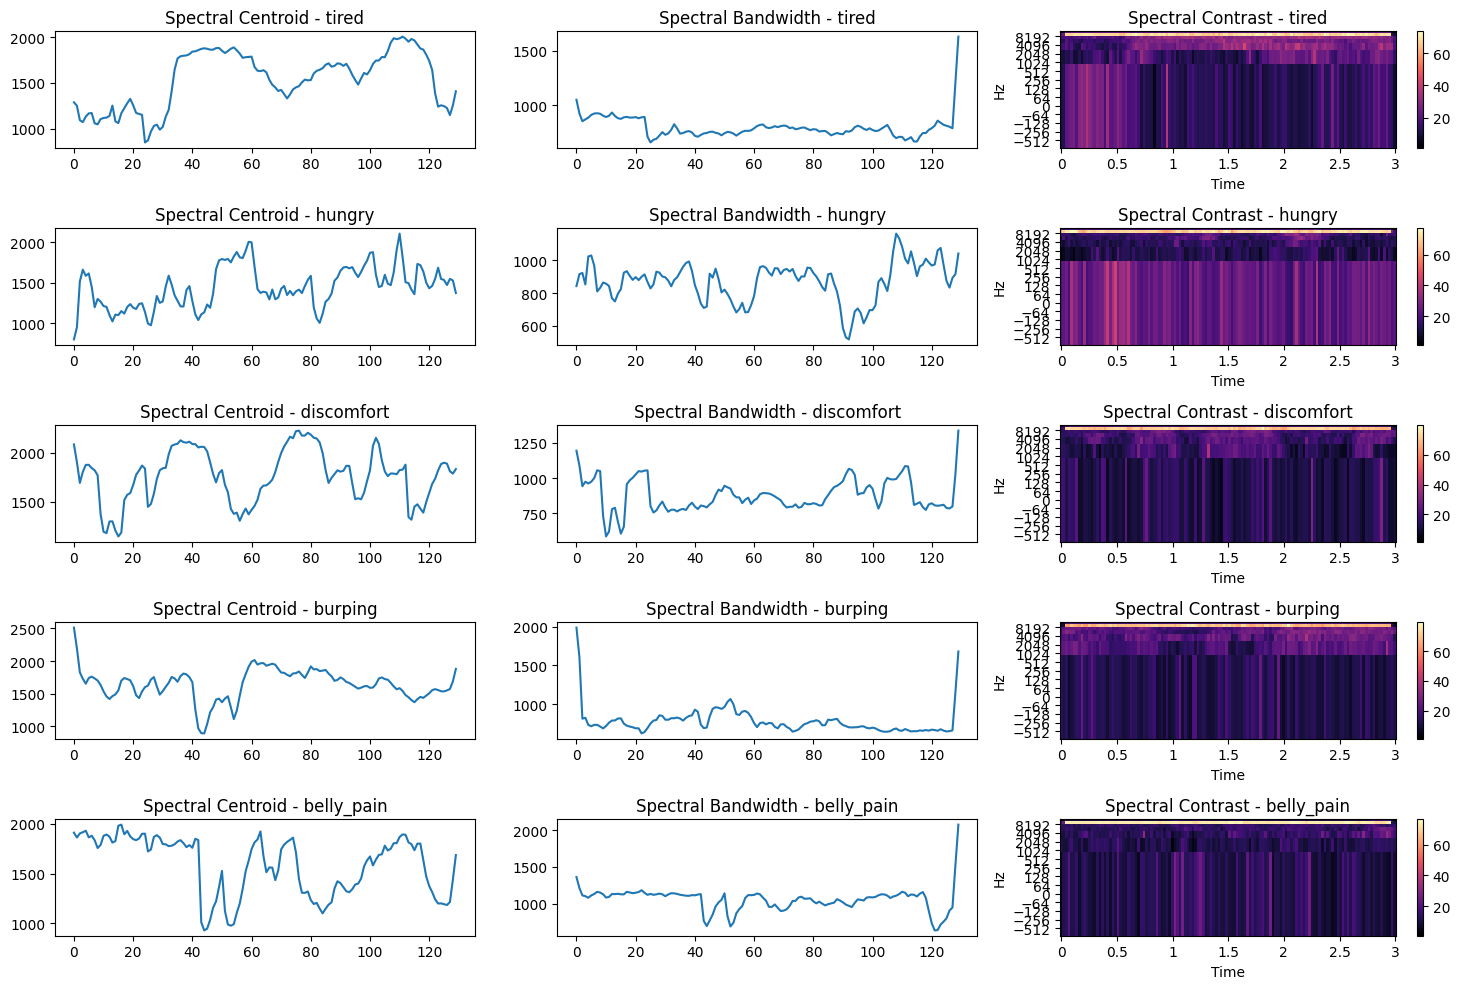

In [25]:
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    if len(audio_data[cls]) > 0:
        sample_audio = audio_data[cls][0]  # First sample from each class

        plt.subplot(len(classes), 3, i * 3 + 1)
        spectral_centroid = librosa.feature.spectral_centroid(y=sample_audio, sr=sr)
        plt.plot(spectral_centroid[0])
        plt.title(f"Spectral Centroid - {cls}")

        plt.subplot(len(classes), 3, i * 3 + 2)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=sample_audio, sr=sr)
        plt.plot(spectral_bandwidth[0])
        plt.title(f"Spectral Bandwidth - {cls}")

        plt.subplot(len(classes), 3, i * 3 + 3)
        spectral_contrast = librosa.feature.spectral_contrast(y=sample_audio, sr=sr)
        librosa.display.specshow(spectral_contrast, x_axis="time", y_axis="log")
        plt.colorbar()
        plt.title(f"Spectral Contrast - {cls}")

plt.tight_layout()
plt.show()

**Zero Crossing rate**
Measures how frequently the signal changes sign(useful for detecting sharp cry bursts).

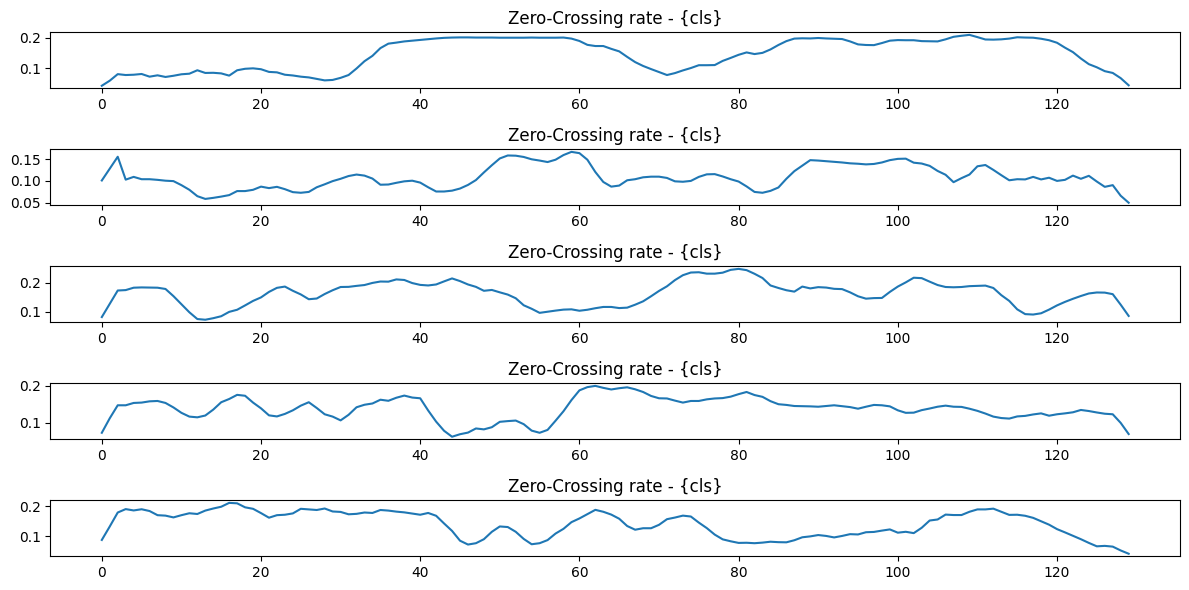

In [28]:
plt.figure(figsize=(12,6))
for i , cls in enumerate(classes):
  if len(audio_data[cls])>0:
    sample_audio=audio_data[cls][0]
    plt.subplot(len(classes),1,i+1)
    zcr=librosa.feature.zero_crossing_rate(sample_audio)[0]
    plt.plot(zcr)
    plt.title("Zero-Crossing rate - {cls}")
plt.tight_layout()
plt.show()

**Wave form represenation**
A simple but useful visualization of the raw r

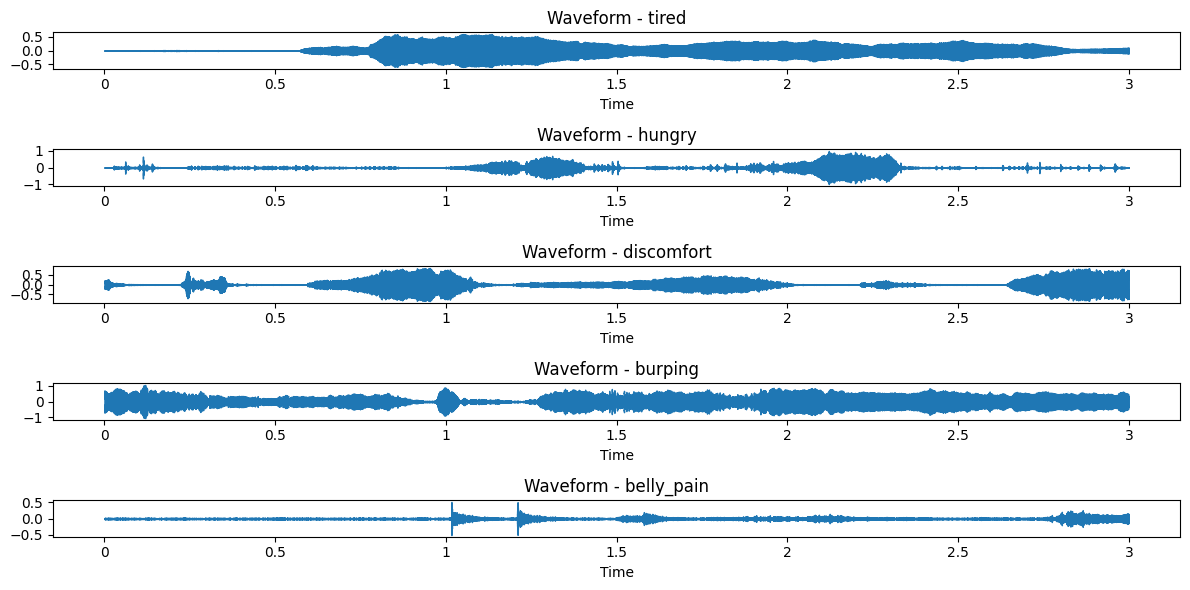

In [29]:
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes):
    if len(audio_data[cls]) > 0:
        sample_audio = audio_data[cls][0]
        plt.subplot(len(classes), 1, i + 1)
        librosa.display.waveshow(sample_audio, sr=sr)
        plt.title(f"Waveform - {cls}")

plt.tight_layout()
plt.show()


**Log Power Spectrogram**

Converts the spectrogram into a log scaler, which is more informative


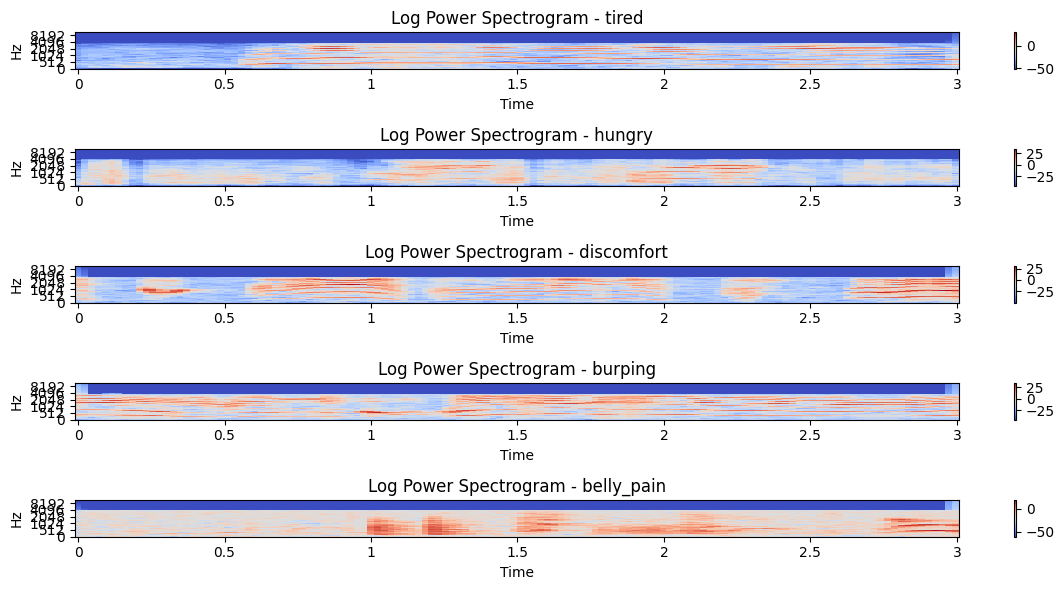

In [30]:
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes):
    if len(audio_data[cls]) > 0:
        sample_audio = audio_data[cls][0]
        spectrogram = librosa.feature.melspectrogram(y=sample_audio, sr=sr, n_mels=128)
        log_spectrogram = librosa.power_to_db(spectrogram)

        plt.subplot(len(classes), 1, i + 1)
        librosa.display.specshow(log_spectrogram, x_axis="time", y_axis="mel", sr=sr)
        plt.colorbar()
        plt.title(f"Log Power Spectrogram - {cls}")

plt.tight_layout()
plt.show()


**Root Mean Square (RMS Energy)**

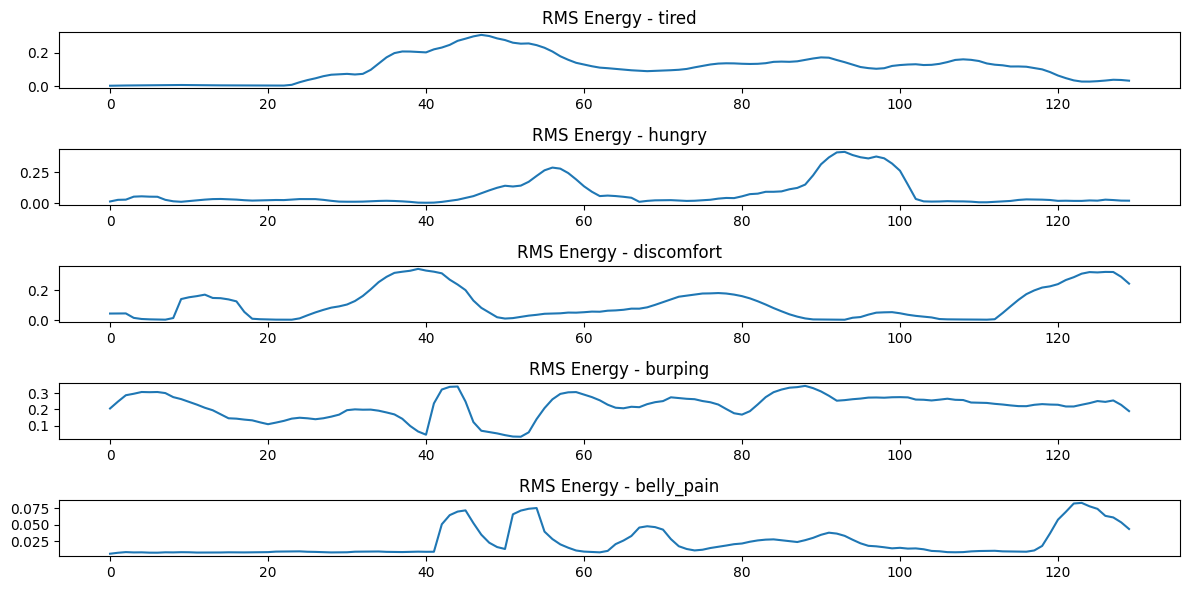

In [31]:
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes):
    if len(audio_data[cls]) > 0:
        sample_audio = audio_data[cls][0]
        rms = librosa.feature.rms(y=sample_audio)[0]
        plt.subplot(len(classes), 1, i + 1)
        plt.plot(rms)
        plt.title(f"RMS Energy - {cls}")

plt.tight_layout()
plt.show()


**Save Features as a CSV File**

In [34]:
classes = ["tired", "hungry", "discomfort", "burping", "belly_pain"]

features=[]
labels=[]

def extract_features(file_path):
  y,sr=librosa.load(file_path,sr=22050)
  mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=13)
  mfcc_mean=np.mean(mfcc,axis=1)
  return mfcc_mean

for cry_class in classes:
  folder_path=f"/content/drive/MyDrive/Augment_Audio_files/{cry_class}"
  for file_name in os.listdir(folder_path):
    file_path=os.path.join(folder_path, file_name)

    try:
      feature_vector=extract_features(file_path)
      features.append(feature_vector)
      labels.append(cry_class)

    except Exception as e:
      print(f"Error processing {file_name}: {e}")


In [36]:
import pandas as pd

df=pd.DataFrame(features)
df["label"]=labels


df.to_csv("infant_cry_features.csv", index=False)
print("Features saved to CSV successfully")

Features saved to CSV successfully
